!!! Please note, that executive block are follow from **3 Executing code**

## TOC:
* [1 Description about VAE](#1-Description-about-VAE)
* [2 Design](#2-Design)
* [3 Executing code](#3-Executing-code)
* [4 Displaying Similar Images](#4-Displaying-Similar-Images)

# 1 Description about VAE

In the last few years, deep learning based generative models have gained more and more interest due to (and implying) some amazing improvements in the field. Relying on huge amount of data, well-designed networks architectures and smart training techniques, deep generative models have shown an incredible ability to produce highly realistic pieces of content of various kind, such as images, texts and sounds. Among these deep generative models, two major families stand out and deserve a special attention: Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. Moreover, the term “variational” comes from the close relation there is between the regularisation and the variational inference method in statistics.

## 1.1 Constructing the VAE

The VAE’s architecture consists of two parts — the encoder and decoder.

The encoder is utilized for mapping the input to a latent space, while the decoder maps the latent space back to the original input.

Because the decoder is used to reconstruct input information, it’s built as the exact opposite of the encoder. Putting the encoder and decoder together makes the VAE’s signature bowtie-like shape.

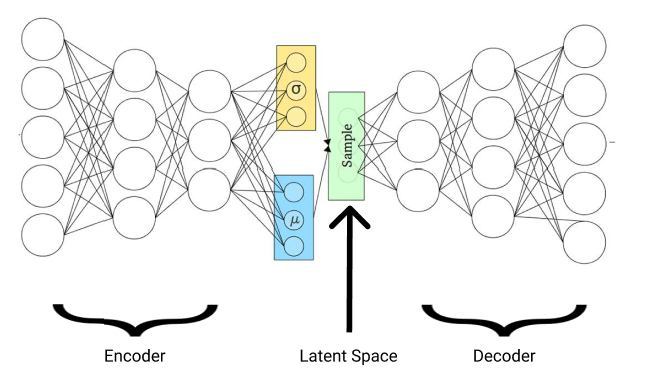

However, in the VAE, the encoder doesn’t directly map to the latent space. Rather, it first uses the input data to output two quantities called mu (the u symbol) and sigma (the o symbol).

# 2 Design

## 2.1 Notes about creating a variational autoencoder

* The embeddings of each image will be used as a low dimensional representation of the image.
* Cosine Similarity of the images are calculated against each other.

## 2.2 Add required libraries

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import os
cwd = os.getcwd()
import time
import numpy as np
import pandas as pd
import subprocess
import os
from datetime import datetime,timedelta
from datetime import date
import urllib.request
from PIL import Image

## 2.3 Import Data, Create train and test sets and rescaling

Be shure that you unzip the data set from ***'./design_and_dataset/archive.zip'*** in ***'./input/fruits/fruits-360/Training'***

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
 
## Finds images
train_data_path = '../input/fruits/fruits-360/Training'
 
### Rescaling incoming image to 28 by 28 pixels
### After Rescaling, convert the image to a tensor
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
test_loader = train_loader

## 2.4 Declare the model architecture

In [ ]:
d = 20
 
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=2,kernel_size=3,padding=0,stride=1),
            nn.ReLU(),
        nn.BatchNorm2d(2)
        )
        self.fc1 = nn.Sequential(
            ### Reduce the number of channels to 1 without changing the width and dimensions of the images
            nn.Linear(26*26*2,128),
            
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,32)
            
        )
 
        self.encoder = nn.Sequential(
            
            nn.Linear(32, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )
        
 
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 32)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,26*26*2),
            nn.ReLU(),
            nn.BatchNorm1d(26*26*2)
            
        )
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2,out_channels=3,kernel_size=3,stride=1,padding=0),
            
            nn.Sigmoid()
        
        )
 
    def reparameterise(self, mu, logvar):
        if self.training:
            ## Using log variance to ensure that we get a positive std dev
            ## Converting to std dev in the real space
            std = logvar.mul(0.5).exp_()
            ### Create error term which has the same shape as std dev sampled from a N(0,1) distribution
            eps = std.data.new(std.size()).normal_()
            #eps = torch.zeros(std.size())
            ### Add the mean and the std_dev 
            return eps.mul(std).add_(mu)
        else:
            return mu
 
    def forward(self, x):
        
        #fc1_output = self.fc1(x.view(-1, 28*28*3))
        conv1_output = self.conv1(x)
        #print(conv1_output.size())
        fc1_output = self.fc1(conv1_output.view(-1,26*26*2))
        
        ### Convert Encoded vector into shape (N,2,d)
        mu_logvar = self.encoder(fc1_output).view(-1, 2, d)
        ### First vector for each image is mean of the latent distribution
        mu = mu_logvar[:, 0, :]
        ### Second vector for each image is log-variance of the latent distribution
        logvar = mu_logvar[:, 1, :]
        ### Create variable Z = mu + error * Std_dev
        z = self.reparameterise(mu, logvar)
        ### Get decoder output
        decoder_output = self.decoder(z)
        
        fc2_output = self.fc2(decoder_output)
        tconv1_output = self.tconv1(fc2_output.view(fc2_output.size(0),2,26,26))
        ## Resize Decoder Output to Pass it to TransposedConv2d layer to recontruct 3 channeled image
        #decoder_output = decoder_output.view(decoder_output.size(0),1,28,28) 
        ## Return Reconstructed Output and mean and log-variance
        return tconv1_output, mu, logvar,z
    
model = VAE()

## 2.5 Declare the optimizer and learning rate

In [ ]:
learning_rate = 3e-3
 
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
    )
### Loss function
 
#Reconstruction + KL divergence losses summed over all elements and batch
 
def loss_function(x_hat, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')
    ## Making sure that distributions do not overlap
#     loss = nn.functional.binary_cross_entropy(
#         x_hat, x, reduction='sum'
#     )
    loss = MSE(x_hat,x)
    #loss = MSE(x_hat,x.view(x.size(0), -1))
#     BCE = nn.functional.binary_cross_entropy(
#         x_hat, x.view(-1, 28*28*3), reduction='sum'
#     )
    ### Makes sure that distributions of each image span entire latent space and the range does not explode
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
 
    return loss + KLD

## 2.6 Training the model

In [ ]:
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list())
 
loss = {
    'train_loss':[],
    'test_loss' : []
}
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            #x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar,_ = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        
        #loss['train_loss'].append(train_loss)
        if epoch % 1 ==0:
            print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, _ in test_loader:
            #x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar,_ = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            #labels.append(y.detach())
    # ===================log========================
    #loss['test_loss'].append(test_loss)
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    test_loss /= len(test_loader.dataset)
    if epoch % 1 == 0:
        print(f'====> Test set loss: {test_loss:.4f}')
        #display_images(x, x_hat, 1, f'Epoch {epoch}')
        #plt.show()

## 2.7 Extract embeddings

In [ ]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
 
torch.save(checkpoint, 'checkpoint.pth')

# 3 Executing code

In [2]:
### Get Library
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import os
cwd = os.getcwd()
import time
import numpy as np
import pandas as pd
import subprocess
import os
from datetime import datetime,timedelta
from datetime import date
import urllib.request
from PIL import Image
 
print('----------------------- Libraries are imported ---------------------------')
 
### Import Data and Create Train and test sets
 
torch.manual_seed(42)
torch.cuda.manual_seed(42)
 
## Finds images
train_data_path = '../input/fruits/fruits-360/Training'
 
### Rescaling incoming image to 28 by 28 pixels
### After Rescaling, convert the image to a tensor
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
test_loader = train_loader
##### Declare the model architecture
 
d = 20
 
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=2,kernel_size=3,padding=0,stride=1),
            nn.ReLU(),
        nn.BatchNorm2d(2)
        )
        self.fc1 = nn.Sequential(
            ### Reduce the number of channels to 1 without changing the width and dimensions of the images
            nn.Linear(26*26*2,128),
            
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,32)
            
        )
 
        self.encoder = nn.Sequential(
            
            nn.Linear(32, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )
        
 
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 32)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,26*26*2),
            nn.ReLU(),
            nn.BatchNorm1d(26*26*2)
            
        )
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2,out_channels=3,kernel_size=3,stride=1,padding=0),
            
            nn.Sigmoid()
        
        )
 
    def reparameterise(self, mu, logvar):
        if self.training:
            ## Using log variance to ensure that we get a positive std dev
            ## Converting to std dev in the real space
            std = logvar.mul(0.5).exp_()
            ### Create error term which has the same shape as std dev sampled from a N(0,1) distribution
            eps = std.data.new(std.size()).normal_()
            #eps = torch.zeros(std.size())
            ### Add the mean and the std_dev 
            return eps.mul(std).add_(mu)
        else:
            return mu
 
    def forward(self, x):
        
        #fc1_output = self.fc1(x.view(-1, 28*28*3))
        conv1_output = self.conv1(x)
        #print(conv1_output.size())
        fc1_output = self.fc1(conv1_output.view(-1,26*26*2))
        
        ### Convert Encoded vector into shape (N,2,d)
        mu_logvar = self.encoder(fc1_output).view(-1, 2, d)
        ### First vector for each image is mean of the latent distribution
        mu = mu_logvar[:, 0, :]
        ### Second vector for each image is log-variance of the latent distribution
        logvar = mu_logvar[:, 1, :]
        ### Create variable Z = mu + error * Std_dev
        z = self.reparameterise(mu, logvar)
        ### Get decoder output
        decoder_output = self.decoder(z)
        
        fc2_output = self.fc2(decoder_output)
        tconv1_output = self.tconv1(fc2_output.view(fc2_output.size(0),2,26,26))
        ## Resize Decoder Output to Pass it to TransposedConv2d layer to recontruct 3 channeled image
        #decoder_output = decoder_output.view(decoder_output.size(0),1,28,28) 
        ## Return Reconstructed Output and mean and log-variance
        return tconv1_output, mu, logvar,z
    
model = VAE()
 
print('----------------------- Model has been Initialized ---------------------------')
 
 
#### Declare the optimizer and learning rate
 
learning_rate = 3e-3
 
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
    )
### Loss function
 
#Reconstruction + KL divergence losses summed over all elements and batch
 
def loss_function(x_hat, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')
    ## Making sure that distributions do not overlap
#     loss = nn.functional.binary_cross_entropy(
#         x_hat, x, reduction='sum'
#     )
    loss = MSE(x_hat,x)
    #loss = MSE(x_hat,x.view(x.size(0), -1))
#     BCE = nn.functional.binary_cross_entropy(
#         x_hat, x.view(-1, 28*28*3), reduction='sum'
#     )
    ### Makes sure that distributions of each image span entire latent space and the range does not explode
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
 
    return loss + KLD
 
##### Training the model
print('----------------------- Training is started ---------------------------')
 
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list())
 
loss = {
    'train_loss':[],
    'test_loss' : []
}
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            #x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar,_ = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        
        #loss['train_loss'].append(train_loss)
        if epoch % 1 ==0:
            print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, _ in test_loader:
            #x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar,_ = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            #labels.append(y.detach())
    # ===================log========================
    #loss['test_loss'].append(test_loss)
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    test_loss /= len(test_loader.dataset)
    if epoch % 1 == 0:
        print(f'====> Test set loss: {test_loss:.4f}')
        #display_images(x, x_hat, 1, f'Epoch {epoch}')
        #plt.show()
 
#### Extract embeddings
print('----------------------- Training has ended ---------------------------')
 
 
 
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
 
torch.save(checkpoint, 'checkpoint.pth')
 
print('----------------------- Save the Model ---------------------------')

----------------------- Libraries are imported ---------------------------
----------------------- Model has been Initialized ---------------------------
----------------------- Training is started ---------------------------
====> Test set loss: 291.3014
====> Epoch: 1 Average loss: 69.4303
====> Test set loss: 47.7163
====> Epoch: 2 Average loss: 51.8106
====> Test set loss: 47.3746
====> Epoch: 3 Average loss: 49.5050
====> Test set loss: 41.8160
====> Epoch: 4 Average loss: 48.2007
====> Test set loss: 43.4643
====> Epoch: 5 Average loss: 47.3119
====> Test set loss: 40.0371
====> Epoch: 6 Average loss: 46.5672
====> Test set loss: 39.0267
====> Epoch: 7 Average loss: 45.8481
====> Test set loss: 39.9266
====> Epoch: 8 Average loss: 45.4018
====> Test set loss: 40.0597
====> Epoch: 9 Average loss: 45.0795
====> Test set loss: 38.9522
====> Epoch: 10 Average loss: 44.6130
====> Test set loss: 39.8976
====> Epoch: 11 Average loss: 44.3386
====> Test set loss: 37.6115
====> Epoch: 12 

# 4 Displaying Similar Images

* Choose images from test-multiple-fruits folder
* Extract mean vector for each image
* Calculate cosine silimarity of mean vector of each image to each other
* Choose 5 random images and display the top five images close to these images.

Similar Images to :
cherries5.jpg
---


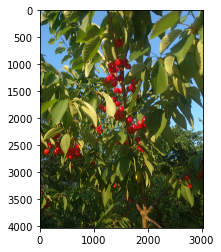

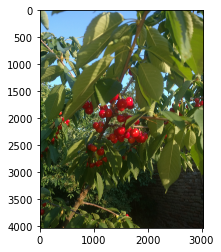

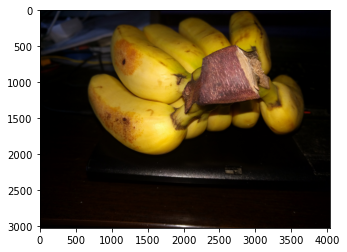

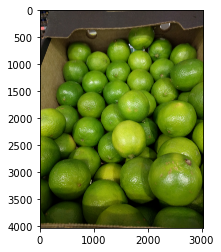

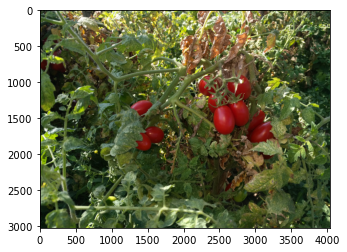

Similar Images to :
cherry_strawberries2.jpg
---


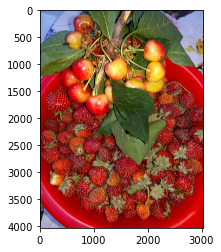

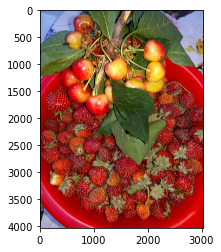

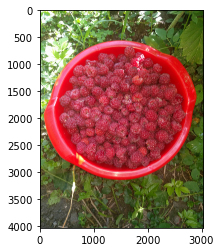

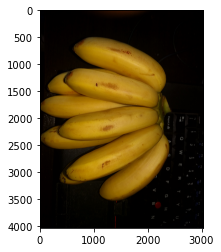

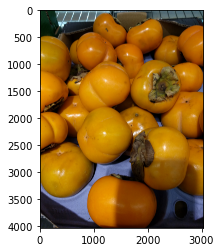

Similar Images to :
kachi.jpg
---


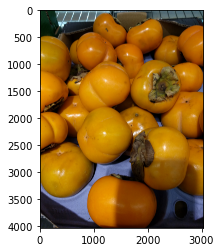

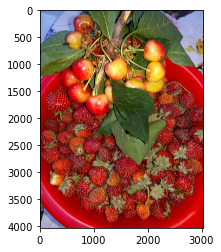

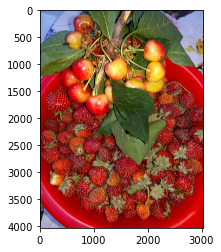

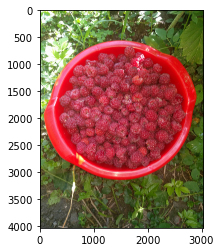

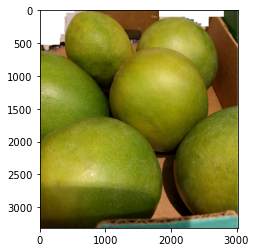

Similar Images to :
Bananas(lady_finger)3.jpg
---


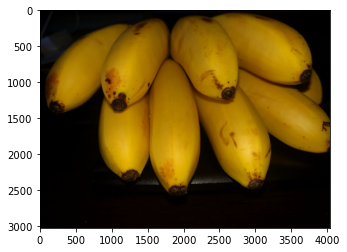

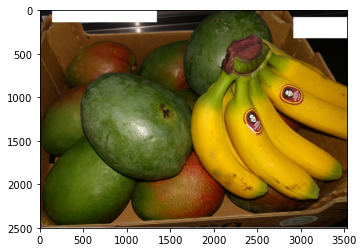

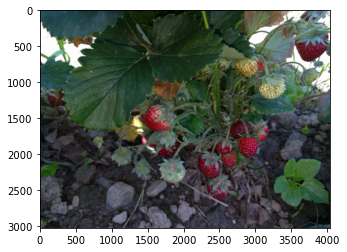

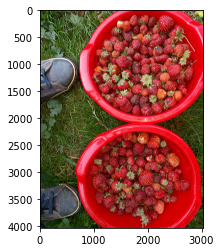

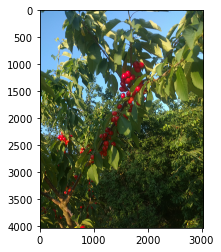

Similar Images to :
apple.jpg
---


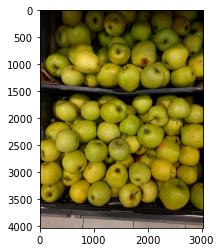

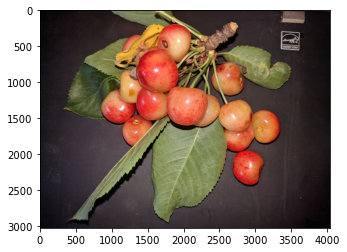

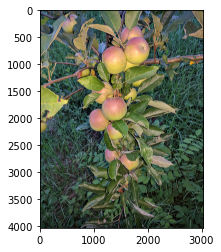

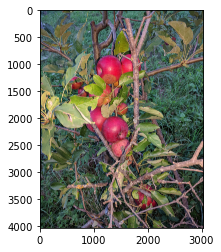

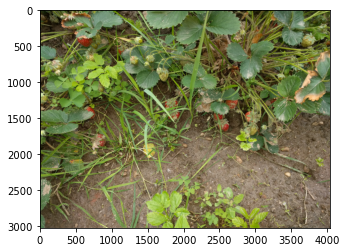

In [3]:
import numpy as np
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])

model.eval()

image_names = []
image_embeddings = np.zeros((103,d))
count = 0

for i in os.listdir('../input/fruits/fruits-360/test-multiple_fruits/'):
    image_path = '../input/fruits/fruits-360/test-multiple_fruits/'+i
    img = Image.open(image_path)
    img = transform(img)
    img = img.view(1,3,28,28)
    x_hat,mu,sigma,embedding_vector = model(img)
    image_names.append(i)
    embedding_vector = mu.detach().numpy()
    image_embeddings[count,:] = embedding_vector
    count = count+1
from numpy import array as a
from numpy.linalg.linalg import norm
from numpy import set_printoptions

M = image_embeddings   # create demo matrix

# dot products of rows against themselves
DotProducts = M.dot(M.T);       

# kronecker product of row norms
NormKronecker = a([norm(M, axis=1)]) * a([norm(M, axis=1)]).T; 

CosineSimilarity = DotProducts / NormKronecker
import pandas as pd
df_vae = pd.DataFrame(CosineSimilarity)
df_vae.index = image_names
df_vae.columns = image_names
import random
num_selected = 5
list_of_random_items = random.sample(image_names, num_selected)
from matplotlib import pyplot as plt

for image in list_of_random_items:
    filtered_df = df_vae[[image]].sort_values(by=image,ascending=False)
    ### Selected top n 
    n = 5
    filtered_df = filtered_df.head(n)
    images_recommended = filtered_df.index
    print('Similar Images to :')
    print(image)
    print('---')
    for image_reco in images_recommended:
        im = Image.open('../input/fruits/fruits-360/test-multiple_fruits/'+str(image_reco))
        plt.imshow(im)
        plt.pause(0.5)
        
